In [2]:
import random
import torch
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional

torch.manual_seed(42)

## Various sine function

In [3]:
# a random complex tensor of size (3,2,4):
x = torch.randn(3, 2, 4, dtype=torch.complex64)

In [4]:
T = 0.1024
fs = 5000
# meaning n_samples = T * fs = 0.1024 * 5000 = 512 (same as our windowed data)
frequencies = [20, 90]  # Hz
t = torch.arange(0, T, 1 / fs)
L = len(t)

#### sum of sines

In [5]:
sine_wave = torch.zeros_like(t)
cos_wave = torch.zeros_like(t)
for freq in frequencies:
	sine_wave += torch.sin(2 * np.pi * freq * t)
	cos_wave += torch.cos(2 * np.pi * freq * t)

#### changing freq

In [6]:
transition_point = int(0.5 * L)  # Number of samples before frequency transition
changing_sine = torch.zeros_like(t)
changing_sine[:transition_point] = torch.sin(2 * torch.pi * frequencies[0] * t[:transition_point])
changing_sine[transition_point:] = torch.sin(2 * torch.pi * frequencies[-1] * t[transition_point:])

#### chirp

In [7]:
f0 = frequencies[0]  # starting frequency in Hz
fn = frequencies[-1]  # ending frequency in Hz
t = torch.linspace(0, T, int(T * fs), dtype=torch.float32)
omega = 2 * torch.pi * (f0 + (fn - f0) * t / T)
chirp = torch.sin(omega * t)

In [8]:
multifeature = torch.stack([sine_wave, changing_sine, chirp], dim=1)

#### real force data

In [9]:
read_from = 'ours'
if read_from == 'prssm':
	fs = 25
	T = 256 / fs
	try:
		forces = torch.load(r'G:\My Drive\Master\Lab\Thesis\Results\10_10_2023\forces_prssm.pt')
	except FileNotFoundError:
		forces = torch.load(r'/home/hadar/Thesis/Results/10_10_2023/forces_prssm.pt')
else:
	try:
		forces = torch.load(r'G:\My Drive\Master\Lab\Thesis\Results\22_11_2023\f19+f23_list_clean.pt')
	except FileNotFoundError:
		forces = torch.load(r'/home/hadar/Thesis/Results/22_11_2023/f19+f23_list_clean.pt')

In [10]:
random_force_index = random.randint(0, len(forces) - 1)
f_dataset = forces[random_force_index]
window_size = int(T * fs)
window_start = random.randint(0, len(f_dataset) - window_size)
window_end = window_start + window_size
window = f_dataset[window_start:window_end, :]
f1, f2, f3, f4 = window[:, 0], window[:, 1], window[:, 2], window[:, 3]
print('dataset index:', random_force_index, f'(out of {len(forces) - 1})')
print(f'window index: [{window_start}, {window_start + 1},...,{window_end}] (size {window_size})',
	  f'within the dataset with indices [0,1,...,{len(f_dataset) - 1}] (size {len(f_dataset)})')


dataset index: 73 (out of 152)
window index: [2019, 2020,...,2531] (size 512) within the dataset with indices [0,1,...,3547] (size 3548)


In [11]:
print(multifeature.shape)
print(torch.fft.rfft(multifeature, axis=0).shape)
print(torch.fft.rfftfreq(multifeature.shape[0], 1 / fs))

torch.Size([512, 3])
torch.Size([257, 3])
tensor([   0.0000,    9.7656,   19.5312,   29.2969,   39.0625,   48.8281,
          58.5938,   68.3594,   78.1250,   87.8906,   97.6562,  107.4219,
         117.1875,  126.9531,  136.7188,  146.4844,  156.2500,  166.0156,
         175.7812,  185.5469,  195.3125,  205.0781,  214.8438,  224.6094,
         234.3750,  244.1406,  253.9062,  263.6719,  273.4375,  283.2031,
         292.9688,  302.7344,  312.5000,  322.2656,  332.0312,  341.7969,
         351.5625,  361.3281,  371.0938,  380.8594,  390.6250,  400.3906,
         410.1562,  419.9219,  429.6875,  439.4531,  449.2188,  458.9844,
         468.7500,  478.5156,  488.2812,  498.0469,  507.8125,  517.5781,
         527.3438,  537.1094,  546.8750,  556.6406,  566.4062,  576.1719,
         585.9375,  595.7031,  605.4688,  615.2344,  625.0000,  634.7656,
         644.5312,  654.2969,  664.0625,  673.8281,  683.5938,  693.3594,
         703.1250,  712.8906,  722.6562,  732.4219,  742.1875,  751.95

In [12]:
class Dataset:
	def __init__(self, data, name, fs):
		self.name = name
		self.fft = None
		self.raw_fft = None
		self.fftfreq = None
		self.raw_fftfreq = None
		self.stft = None
		self.fs = fs
		self.data = self._parse_data(data)

	def __str__(self):
		if self.name == 'sine':
			return r'$f(t)=$' + '+'.join([rf'$sin(2\pi\cdot{f}t)$' for f in frequencies])
		else:
			return self.name

	def _parse_data(self, data, window=False):
		"""
        the number of fft bins is nyquist = fs/2 = 2500. this means that len(data) points are spread across 2500 bins.
        we want to have at least 2500 points, so we pad the data with zeros to reach that number.
        but through experiments i can tell that this is still nout enough, so i double that number in the power of two.
        """
		# return data
		# data = torch.from_numpy(signal.savgol_filter(
		#     x=data,
		#     window_length=5,
		#     polyorder=3
		# ))
		# if window:
		#     data *= torch.hann_window(len(data))
		# pad_size = self.fs // 2 - len(data)
		# pad_size = 2 ** (int(np.ceil(np.log2(pad_size))) + 1)  # round pad_size to the nearest power of two for fast FFT
		# data = F.pad(data, (0, pad_size), value=0)
		return data

	def calc_fft(self, shapes=True, freq_threshold: Optional[float] = None):
		if freq_threshold is None:
			freq_threshold = self.fs / 2  # Nyquist, which is the default x axis value anyway
		fft = torch.fft.rfft(self.data)
		freqs = torch.fft.rfftfreq(len(self.data), 1 / self.fs)
		fft = fft[freqs <= freq_threshold]
		freqs = freqs[freqs <= freq_threshold]
		print(fft.shape)
		print(freqs.shape)
		self.fft = {'fft': fft, 'magnitude': fft.abs(), 'angle': fft.angle(), 'freqs': freqs}
		if shapes:
			print('FFT shape:', self.fft['fft'].shape)
			print('Frequencies:', f"[{freqs[0]}, {freqs[1]}, {freqs[2]}, ..., {freqs[-2]}, {freqs[-1]}]")

	def calc_stft(self, n_fft=200, hop_length=None, win_length=None, pad_mode='reflect', apply_abs=True, shapes=True):
		if win_length is None:
			win_length = n_fft
		if hop_length is None:
			hop_length = n_fft // 4
		stft = torch.stft(
			input=self.data,
			n_fft=n_fft,
			hop_length=hop_length,  #default n_fft/4
			win_length=win_length,  #default n_fft
			window=torch.hann_window(win_length),  # hann is a cosine window with ends that touch zero
			center=False,
			pad_mode=pad_mode,
			normalized=False,  # not normalized
			onesided=True,  # only return the positive frequencies
			return_complex=True  # return complex numbers
		)
		if apply_abs:
			stft = torch.abs(stft)
		self.stft = stft
		if shapes:
			print("Spectrogram shape is (B?, N, T, C?), where:")
			print(f' - B --> None')
			print(f' - N --> (n_fft//2)+1=({n_fft}//2)+1={(n_fft // 2) + 1}')
			print(
				f" - T --> 1+(L-n_fft)//hop_length=1+({len(self.data)}-{n_fft})//{hop_length}={1 + (len(self.data) - n_fft) // hop_length}")
			print(f" - C --> None")
			print(f'STFT shape: {stft.shape}')



In [13]:
dataset = Dataset(sine_wave, 'sine', fs=fs)
dataset.calc_fft(freq_threshold=200)
n_fft = int(0.25 * len(dataset.data))
hop_length = n_fft // 32
window_len = n_fft // 16
dataset.calc_stft(n_fft=n_fft, hop_length=hop_length)

torch.Size([21])
torch.Size([21])
FFT shape: torch.Size([21])
Frequencies: [0.0, 9.765625, 19.53125, ..., 185.546875, 195.3125]
Spectrogram shape is (B?, N, T, C?), where:
 - B --> None
 - N --> (n_fft//2)+1=(128//2)+1=65
 - T --> 1+(L-n_fft)//hop_length=1+(512-128)//4=97
 - C --> None
STFT shape: torch.Size([65, 97])


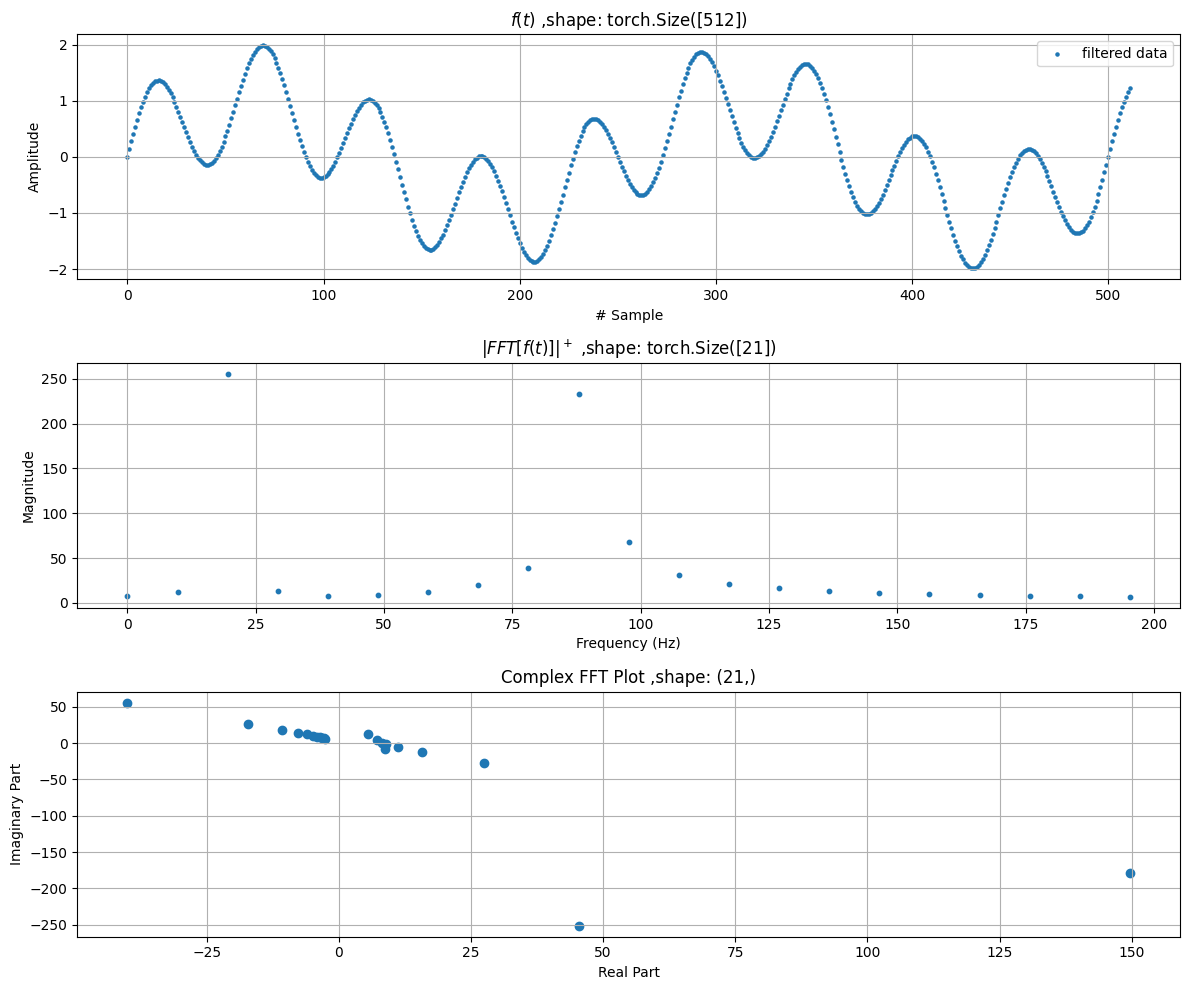

In [14]:
import matplotlib

# matplotlib.use('TkAgg')
plt.figure(figsize=(12, 10))

# Subplot 1: Input signal
plt.subplot(3, 1, 1)
plt.scatter(torch.arange(len(dataset.data)), dataset.data, s=5, label='filtered data')
plt.title(r'$f(t)$' + ' ,shape: ' + str(dataset.data.shape)), plt.xlabel('# Sample'), plt.ylabel('Amplitude')
plt.grid(), plt.legend()

# Subplot 2: FFT
plt.subplot(3, 1, 2)
plt.scatter(dataset.fft['freqs'], dataset.fft['magnitude'], s=10, label='FFT[filtered data]')
plt.title(r'$|FFT[f(t)]|^+$' + ' ,shape: ' + str(dataset.fft['fft'].shape)), plt.xlabel('Frequency (Hz)'), plt.ylabel(
	'Magnitude'), plt.grid()

plt.subplot(3, 1, 3)
complex_fft = dataset.fft['fft'].numpy()

# Plot complex FFT values as lines
plt.scatter(dataset.fft['fft'].real, dataset.fft['fft'].imag)
plt.title('Complex FFT Plot' + ' ,shape: ' + str(complex_fft.shape)), plt.xlabel('Real Part'), plt.ylabel(
	'Imaginary Part')
plt.grid()

# # Subplot 3: Spectrogram
# plt.subplot(3, 1, 3)
# stft_np = dataset.stft.numpy()
# plt.imshow(stft_np, aspect='auto', cmap='viridis', origin='lower', extent=[0, stft_np.shape[1], 0, fs / 2])
# plt.colorbar(label='Magnitude')
# plt.title('Spectrogram' + ' ,shape: ' + str(dataset.stft.shape)), plt.xlabel('Time (s)'), plt.ylabel('Frequency (Hz)')
# # plt.ylim(0, max(top_k_freqs) + 100)
# # plt.ylim(0,30)
plt.tight_layout()
plt.show()



## Test FFT with low pass filter + padding to IFFT

In [15]:
print('Original shape: ', multifeature.shape)
regular_fft = torch.fft.rfft(multifeature, dim=0)
print('Regular FFT shape: ', regular_fft.shape)
regular_ifft = torch.fft.irfft(regular_fft, dim=0)
print('Regular IFFT shape: ', regular_ifft.shape)
print('=' * 50)
filtered_fft = regular_fft[:10, :]  # 50 is the number of frequencies we want to keep
print('Filtered FFT shape: ', filtered_fft.shape)
padded_filtered_fft = torch.nn.functional.pad(filtered_fft, (0, 0, 0, (len(multifeature) // 2 + 1) - len(filtered_fft)))
print('Zero Padded Filtered FFT shape: ', padded_filtered_fft.shape)
padded_filtered_ifft = torch.fft.irfft(padded_filtered_fft, dim=0)
print('IFFT shape: ', padded_filtered_ifft.shape)
reconstructed = torch.fft.irfft(padded_filtered_fft, dim=0)
print('Reconstructed shape: ', reconstructed.shape)

Original shape:  torch.Size([512, 3])
Regular FFT shape:  torch.Size([257, 3])
Regular IFFT shape:  torch.Size([512, 3])
Filtered FFT shape:  torch.Size([10, 3])
Zero Padded Filtered FFT shape:  torch.Size([257, 3])
IFFT shape:  torch.Size([512, 3])
Reconstructed shape:  torch.Size([512, 3])


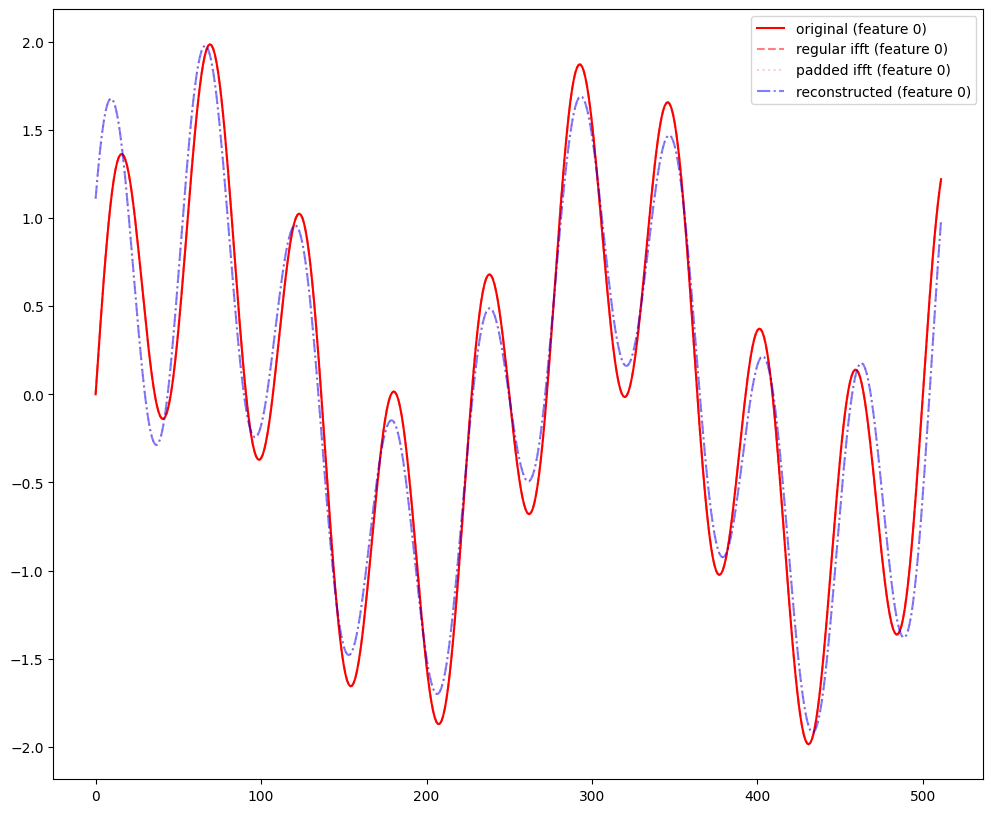

In [16]:
# two plots, one for the regular ifft and one for the ifft on the padded data:
plt.figure(figsize=(12, 10))
plt.plot(multifeature[:, 0].numpy(), label='original (feature 0)', color='red')
# plt.plot(multifeature[:,1].numpy(),label='original (feature 1)',color='green')
# plt.plot(multifeature[:,2].numpy(),label='original (feature 2)',color='blue')
# lighter colors:

plt.plot(regular_ifft[:, 0].numpy(), label='regular ifft (feature 0)', color='red', linestyle='--', alpha=0.5)
# plt.plot(regular_ifft[:,1].numpy(),label='regular ifft (feature 1)',color='green', linestyle='--',alpha=0.5)
# plt.plot(regular_ifft[:,2].numpy(),label='regular ifft (feature 2)',color='blue', linestyle='--',alpha=0.5)

plt.plot(padded_filtered_ifft[:, 0].numpy(), label='padded ifft (feature 0)', linestyle=':', color='red', alpha=0.2)
# plt.plot(padded_filtered_ifft[:,1].numpy(),label='padded ifft (feature 1)', linestyle=':',color='green',alpha=0.2)
# plt.plot(padded_filtered_ifft[:,2].numpy(),label='padded ifft (feature 2)',	linestyle=':',color='blue',alpha=0.2)

plt.plot(reconstructed[:, 0].numpy(), label='reconstructed (feature 0)', linestyle='-.', color='blue', alpha=0.5)
plt.legend()
plt.show()


## Sin + Cos encoding

In [17]:
def sin_encoding(data):
	return torch.sin(2 * np.pi * data / (2 * np.pi))


def cos_encoding(data):
	return torch.cos(2 * np.pi * data / (2 * np.pi))

In [18]:
hours_of_the_week = torch.tensor([i for i in range(24)] * 7)
_sin = sin_encoding(hours_of_the_week)
_cos = cos_encoding(hours_of_the_week)

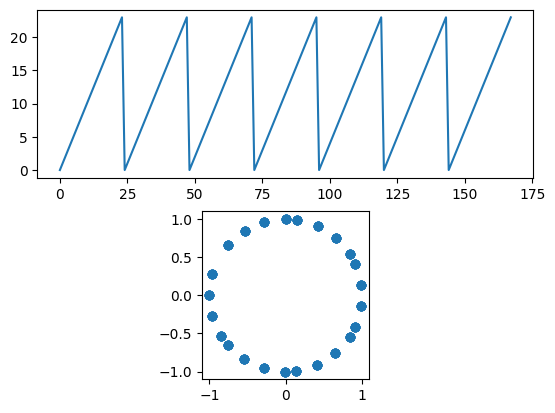

In [19]:
plt.subplot(2, 1, 1)
plt.plot(hours_of_the_week, label='hours of the week')
plt.subplot(2, 1, 2)
plt.scatter(_sin, _cos, label='sin-cos encoding')
# square plot:

plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [20]:
random_angles_in_radians = torch.rand(1000) * 2 * np.pi
_sin = sin_encoding(random_angles_in_radians)
_cos = cos_encoding(random_angles_in_radians)

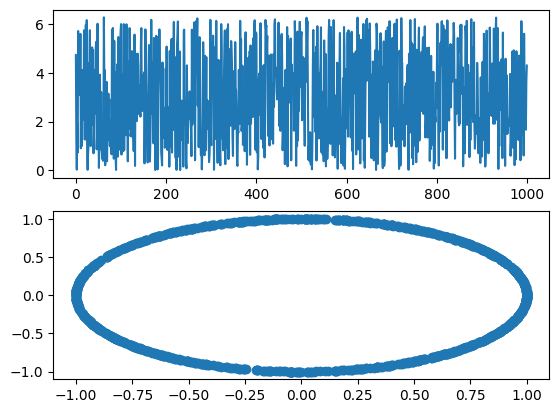

In [21]:
plt.subplot(2, 1, 1)
plt.plot(random_angles_in_radians, label='random angles in radians')
plt.subplot(2, 1, 2)
plt.scatter(_sin, _cos, label='sin-cos encoding')
plt.show()

## Test the scale preserving property of fft and ifft

In [22]:
print('Original shape: ', multifeature.shape)
regular_fft = torch.fft.rfft(multifeature, dim=0)
print('Regular FFT shape: ', regular_fft.shape)
regular_ifft = torch.fft.irfft(regular_fft, dim=0)
print('Regular IFFT shape: ', regular_ifft.shape)
print('=' * 50)
filtered_fft = regular_fft[:10, :]  # 50 is the number of frequencies we want to keep
print('Filtered FFT shape: ', filtered_fft.shape)
padded_filtered_fft = torch.nn.functional.pad(filtered_fft, (0, 0, 0, (len(multifeature) // 2 + 1) - len(filtered_fft)))
print('Zero Padded Filtered FFT shape: ', padded_filtered_fft.shape)
padded_filtered_ifft = torch.fft.irfft(padded_filtered_fft, dim=0)
print('IFFT shape: ', padded_filtered_ifft.shape)

Original shape:  torch.Size([512, 3])
Regular FFT shape:  torch.Size([257, 3])
Regular IFFT shape:  torch.Size([512, 3])
Filtered FFT shape:  torch.Size([10, 3])
Zero Padded Filtered FFT shape:  torch.Size([257, 3])
IFFT shape:  torch.Size([512, 3])


## CSD and Cross-Correlation
The CSD of a signal pair is the Fourier transform of the pair’s cross-correlation. The Fourier transform may be a discrete-time Fourier transform, discrete Fourier transform, or fast Fourier transform (FFT).

In [23]:
#first we calculate the cross corelation with numpy:
signal1 = torch.sin(2 * np.pi * 50 * t)
signal2 = torch.sin(2 * np.pi * 50 * t + np.pi / 2)
corr = np.correlate(signal1.numpy(), signal2.numpy(), mode='full')

In [24]:
# argmax of corr:
lag = np.argmax(corr)

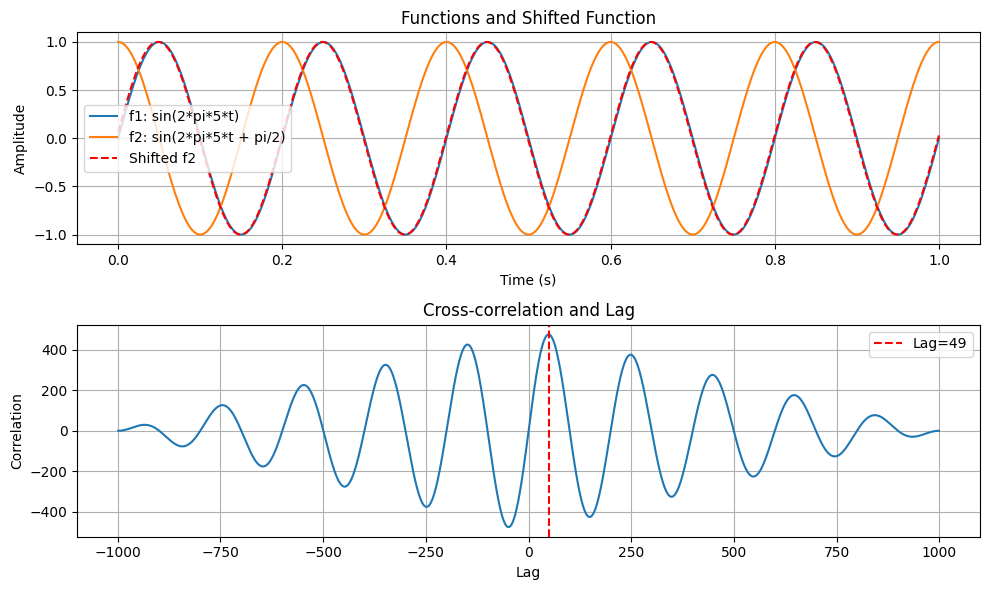

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Define the time axis
t = np.linspace(0, 1, 1000)

# Define the functions
f1 = np.sin(2 * np.pi * 5 * t)
f2 = np.sin(2 * np.pi * 5 * t + np.pi / 2)

# Compute the correlation using np.correlate
corr = np.correlate(f1, f2, mode='full')

# Find the lag with maximum correlation
lag = np.argmax(corr) - len(f1) + 1

# Shift f2 by the lag
f2_shifted = np.roll(f2, lag)

# Plot f1, f2, and shifted f2
plt.figure(figsize=(10, 6))

# Plot f1 and f2
plt.subplot(2, 1, 1)
plt.plot(t, f1, label='f1: sin(2*pi*5*t)')
plt.plot(t, f2, label='f2: sin(2*pi*5*t + pi/2)')
plt.plot(t, f2_shifted, 'r--', label='Shifted f2')
plt.title('Functions and Shifted Function')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Plot the correlation and vertical line indicating lag
plt.subplot(2, 1, 2)
plt.plot(np.arange(-len(f1) + 1, len(f1)), corr)
plt.axvline(x=lag, color='r', linestyle='--', label=f'Lag={lag}')
plt.title('Cross-correlation and Lag')
plt.xlabel(f'Lag')
plt.ylabel('Correlation')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [26]:
from ML.Core import trainer

ours_best = '/home/hadar/Thesis/ML/saved_models/Input(512, 512, 4)seq2seq[1,eemb10,ehid110,nl1,biFalse,demb10,dhid110,out3adlTrue,cat_adlFalse,complexFalse,gateTrue,multidimfftFalse,freq_thres210,drop0.1,perfreqTrue]_ADL[ours,T=1_2024-02-16_07-15-45'
prssm_best = ''
model = trainer.Trainer.from_model_dirname(ours_best)
preds_df, loss_df = trainer.predict(dataset_name='ours', split='test', add_inputs=False)

ImportError: cannot import name 'Trainer' from partially initialized module 'ML.Core.trainer' (most likely due to a circular import) (G:\My Drive\Master\Lab\Thesis\ML\Core\trainer.py)

attention weights

In [ ]:
import torch;
import numpy as np

x = range(512)
f = torch.stack([
	torch.sin(2 * np.pi * 0.04 * torch.tensor(x)),
	torch.sin(2 * np.pi * 0.04 * torch.tensor(x) + np.pi / 2),
	0.1 + torch.sin(2 * np.pi * 0.02 * torch.tensor(x) + np.pi / 4),
], dim=1)
x = torch.arange(512)
weights = np.vstack(x)

In [ ]:
import matplotlib as mpl
mpl.colormaps['autumn']

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
def plot_with_background(weights, f,cmap='YlGn'):
	"""
	:param weights: weights vector with shape [T] for the background
	:param f: features vector with shape [T,F]
	:return: 
	"""
	cmap=matplotlib.colormaps[cmap]
	weights = np.vstack(weights)
	plt.imshow(weights.T, extent=(0, len(weights), f.min() - 1, f.max() + 1), aspect='auto', cmap=cmap)
	for i in range(f.shape[1]):
		plt.plot(f[:, i], linewidth=2, label=fr'$F_{i}$')
	plt.title('Attention-weighted Input Window')
	plt.xlabel('Frame #'); plt.ylabel('Amplitude')
	plt.colorbar(); plt.legend(); plt.show()

In [ ]:
plot_with_background(weights, f,'Blues')

# psi as a function of phi

In [2]:
import torch
our_kin = torch.load(r'G:\My Drive\Master\Lab\Thesis\Results\22_11_2023\k19+k23_list_clean.pt')

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
lengths = [len(k) for k in our_kin]
print( np.argpartition(lengths, -10)[-10:])
print(len(our_kin[135]))
# pd.DataFrame(our_kin[np.argmax([len(k) for k in our_kin])]).plot()

[ 33  69  31  30 135  64   5  77  39  70]
3712


In [61]:
def plot_angle(kin_tensor, k_idx_list, reverse_time=False, start=None, end=None, x: str=r'$\phi$', y: str=r'$\psi$',cmap='binary'):
    if not start: start = 0
    if not end: end = len(kin_tensor[k_idx_list[0]])
    # Create a new figure with a single row of subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for i, k_idx in enumerate(k_idx_list):
        df = pd.DataFrame(kin_tensor[k_idx]).rename(columns={0: r'$\theta$', 1: r'$\phi$', 2: r'$\psi$'}).iloc[start:end]
        if reverse_time:
            df = df.iloc[::-1]
        # Calculate time values for each row
        t_values = np.linspace(start, end, len(df))
        # Create a color map that maps time values to colors
        cmap = plt.get_cmap(cmap)
        norm = plt.Normalize(vmin=min(t_values), vmax=max(t_values))
        colors = cmap(norm(t_values))
        axs[i].grid()
        axs[i].scatter(x=df[x] * (180/np.pi), y=(90-df[y]* (180/np.pi)), c=colors)
        axs[i].set_title(f'dataset #{k_idx}')
        axs[i].set_axisbelow(True)
        axs[i].yaxis.grid(color='gray',linestyle='dashed')
        axs[i].set_xlabel(f'{x} [deg]',fontsize=14)
        axs[i].set_ylabel(f'{y} [deg]',fontsize=14)
    # Add a color bar to the plot
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axs.ravel().tolist(), pad=0.1,aspect=100,orientation='horizontal')
    # Convert index values to time values in milliseconds and divide by 5000
    tick_positions = np.linspace(0, len(df), 5); print(tick_positions)
    tick_labels = tick_positions / 5000
    cbar.set_ticks(tick_positions)
    cbar.set_ticklabels(tick_labels)
    cbar.set_label('Time [ms]')
    # Adjust the position of the color bar
    cbar.ax.set_position([0.1, 0.1, 0.8, 0.05])
    # Add global labels
    fig.suptitle(f'{y} as a function of {x}',fontsize=18)
    plt.savefig('psi_phi.png')	
    plt.show()

[   0.  500. 1000. 1500. 2000.]


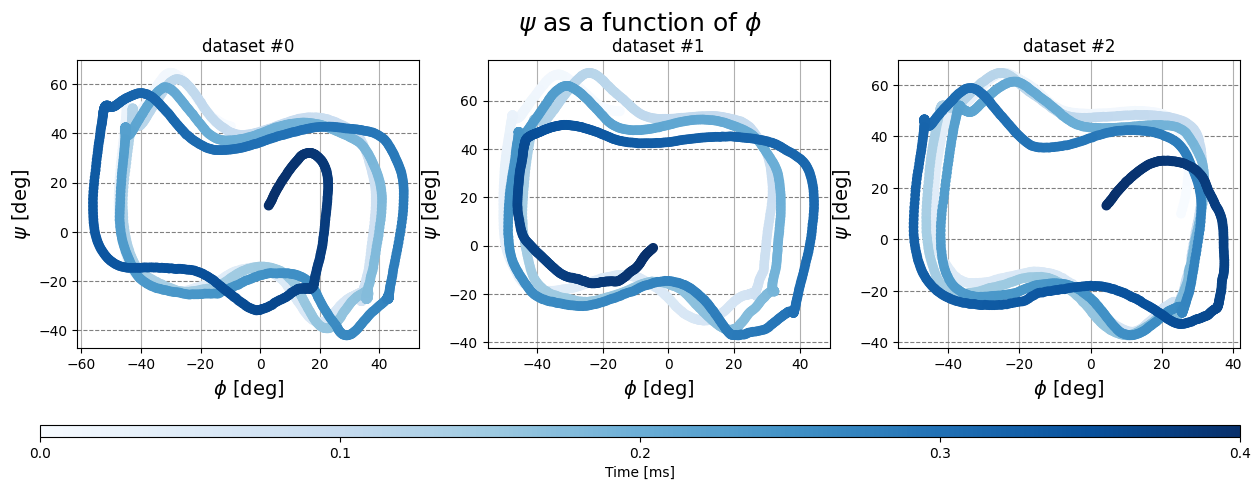

In [62]:
plot_angle(our_kin, [0,1,2],start=0,end=2000,cmap='Blues',reverse_time=True)

In [60]:
def plot_angle_over_time(kin_tensor, k_idx, time_ranges, x: str=r'$\phi$', y: str=r'$\psi$',cmap='Blues',reverse_time=False):
    # Create a new figure with a single row of subplots
    fig, axs = plt.subplots(1, len(time_ranges), figsize=(15, 5))
    
    for i, (start, end) in enumerate(time_ranges):
        df = pd.DataFrame(kin_tensor[k_idx]).rename(columns={0: r'$\theta$', 1: r'$\phi$', 2: r'$\psi$'}).iloc[start:end]
		if reverse_time:
			df = df.iloc[::-1]
        # Calculate time values for each row
        t_values = np.linspace(start, end, len(df))
        
        # Create a color map that maps time values to colors
        cmap = plt.get_cmap(cmap)
        norm = plt.Normalize(vmin=min(t_values), vmax=max(t_values))
        colors = cmap(norm(t_values))
        
        axs[i].grid()
        axs[i].scatter(x=df[x] * (180/np.pi), y=df[y]* (180/np.pi), c=colors)
        axs[i].set_title(f'Time Range: [{start}, {end}]')
        axs[i].set_axisbelow(True)
        axs[i].yaxis.grid(color='gray',linestyle='dashed')
        axs[i].set_xlabel(f'{x} [deg]',fontsize=14)
        axs[i].set_ylabel(f'{y} [deg]',fontsize=14)
    
    # Add a color bar to the plot
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axs.ravel().tolist(), pad=0.1,aspect=100,orientation='horizontal')
    cbar.set_label('Time [ms]')
    
    # Adjust the position of the color bar
    cbar.ax.set_position([0.1, 0.1, 0.8, 0.05])
    
    # Add global labels
    fig.suptitle(f'{y} as a function of {x}',fontsize=18)
    plt.savefig('psi_phi_over_time.png')	
    plt.show()

TabError: inconsistent use of tabs and spaces in indentation (1741079745.py, line 7)

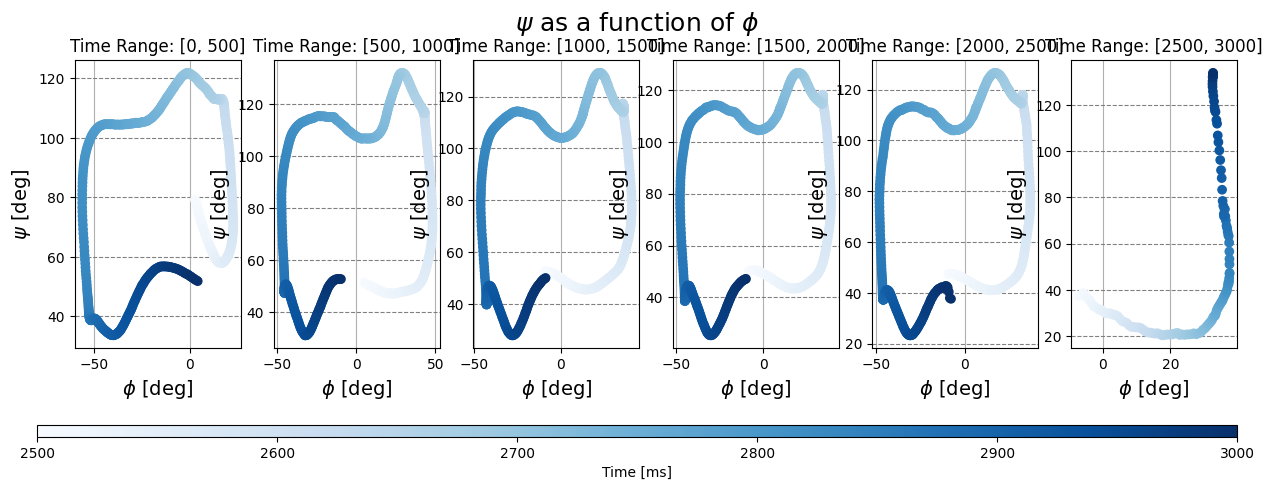

In [58]:
k_idx = 0  # The dataset index to plot
jmp=500
time_ranges = [(i,i+jmp) for i in range(0,3000,jmp)]  # List of time ranges to plot
plot_angle_over_time(our_kin, k_idx, time_ranges,reverse_time=True)

In [1]:
# extracting loss from logs:

In [27]:
log_file_our = '/home/hadar/Thesis/ML/saved_models/Input(512, 512, 4)seq2seq[1,eemb5,ehid40,nl1,biFalse,demb5,dhid40,out3adlTrue,cat_adlFalse,complexFalse,gateTrue,multidimfftFalse,freq_thres190,drop0.1,perfreqTrue]_ADL[ours,T=1_2024-02-15_18-40-38/trainer.log'
log_file_prssm = '/home/hadar/Thesis/ML/saved_models/Input(512, 256, 5)seq2seq[1,eemb5,ehid40,nl1,biFalse,demb5,dhid40,out3adlTrue,cat_adlFalse,complexFalse,gateTrue,multidimfftFalse,freq_thres190,drop0.1,perfreqTrue]_ADL[prssm,T=1_2024-02-16_20-06-34/trainer.log'
with open(log_file_prssm, 'r') as f:
    lines = f.readlines()

In [28]:
loss_dict = dict() # key is best validation loss, value is mean test loss
for i in range(len(lines)):
     if 'mean' in lines[i]:
        best_val = float(lines[i-2].split(' ')[-1].replace('\n',''))
        mean_test = float(lines[i+1].split(' ')[-1].replace('\n',''))
        loss_dict[best_val] = mean_test

In [29]:
loss_dict_sorted_by_keys = dict(sorted(loss_dict.items())) # sorted by best validation loss
loss_dict_sorted_by_values = dict(sorted(loss_dict.items(), key=lambda item: item[1])) # sorted by mean test loss

In [30]:
loss_dict_sorted_by_values

{0.1121: 0.113048,
 0.1113: 0.116871,
 0.1182: 0.118019,
 0.1111: 0.118245,
 0.1125: 0.119131,
 0.1141: 0.119667,
 0.1197: 0.120083,
 0.1143: 0.120323,
 0.115: 0.121109,
 0.1104: 0.122329,
 0.1158: 0.122621,
 0.1187: 0.122872,
 0.1146: 0.12303,
 0.1183: 0.12309,
 0.1206: 0.123147,
 0.1131: 0.123404,
 0.1194: 0.12359,
 0.1142: 0.1236,
 0.1176: 0.123982,
 0.1132: 0.124729,
 0.1185: 0.124733,
 0.1216: 0.124899,
 0.1178: 0.125275,
 0.1153: 0.125312,
 0.119: 0.126204,
 0.1239: 0.126338,
 0.1236: 0.126777,
 0.12: 0.126889,
 0.1123: 0.127072,
 0.1188: 0.127856,
 0.1161: 0.127925,
 0.1175: 0.128907,
 0.1192: 0.128965,
 0.1244: 0.129483,
 0.1136: 0.129835,
 0.1267: 0.129903,
 0.1155: 0.129956,
 0.1204: 0.13018,
 0.118: 0.130328,
 0.1235: 0.130429,
 0.1162: 0.130506,
 0.1168: 0.130522,
 0.1189: 0.130543,
 0.1229: 0.130644,
 0.1218: 0.130724,
 0.1217: 0.131197,
 0.1243: 0.131271,
 0.1272: 0.131351,
 0.1232: 0.131593,
 0.1253: 0.131754,
 0.1169: 0.131791,
 0.1199: 0.132119,
 0.1203: 0.132173,
 0.1

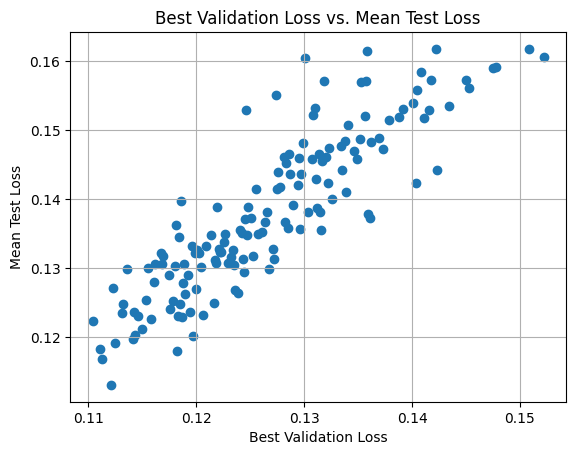

In [31]:
import matplotlib.pyplot as plt


plt.scatter(loss_dict.keys(),loss_dict.values())
plt.title('Best Validation Loss vs. Mean Test Loss')
plt.xlabel('Best Validation Loss')
plt.ylabel('Mean Test Loss')
plt.grid()
plt.show()